In [1]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.linalg
import pyemma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# exercise 1)

In TPT, not every choice of A and B gives a reasonable result.
In contrast to the implied time scales of a MSM, the comittor, the fluxes and mean-first-passage times depend on the lag time.
Consider the following three-state-model.
<img src='../tpt_data/chain.png'>
Here the Markov State model is written with a rate matrix K. We will use this rate matrix to generate different transition matrices for different lag times. T_short with a lag time of 0.001 and T_long with a lag time of 1.

Exercises: compute the committor and the flux for two choices of A and B
- A = [0] and B = [1]
- A = [0] and B = [2]

Compute each of these values for both T_short and T_long.
What do you notice? What do you learn about the choice of the sets A and B?

In [2]:
K = np.array([[-1,    1,  0],
              [100,-300,200],
              [0,     1, -1]])
T_short = sp.linalg.expm(K*0.001)
T_long = sp.linalg.expm(K*1.0)
# or T_long = np.linalg.matrix_power(T_short,1000)

In [3]:
msm_short = pyemma.msm.markov_model(T_short)
tpt_short = pyemma.msm.tpt(msm_short, [0], [1])
tpt_short.forward_committor

array([ 0.        ,  1.        ,  0.95013084])

In [4]:
msm_long = pyemma.msm.markov_model(T_long)
tpt_01_long = pyemma.msm.tpt(msm_long, [0], [1])
tpt_01_long.forward_committor

array([ 0.       ,  1.       ,  0.0156032])

In [5]:
#example with metastable sets
tpt_02_short = pyemma.msm.tpt(msm_short, [0], [2])
tpt_02_short.forward_committor

array([ 0.        ,  0.66666667,  1.        ])

In [6]:
tpt_20_long = pyemma.msm.tpt(msm_long, [0], [2])
tpt_20_long.forward_committor

array([ 0.        ,  0.66666667,  1.        ])

### what do you learn about the choice of the sets A and B?

**solution**: the choice `A=[0]`, `B=[2]` gives stable results at different lag times.
the choice `A=[0]`, `B=[1]` doesn't. There is an indirect transition (0)<->(2) that
becomes very strong at high lag times. Therefore (2) appears highly comitted to (0)
(low forward committor) even though (2) should be committed to (1) because of the network topology.

# Exercise 2) Using PCCA sets

In [7]:
# load Alanine dipetide MSM
T = np.genfromtxt('../tpt_data/T_rev.dat')
lcc = np.genfromtxt('../tpt_data/lcc.dat',dtype=int)
centers = np.genfromtxt('../tpt_data/grid_centers20x20.dat')[lcc , :]
msm = pyemma.msm.markov_model(T, dt_model='3 ps')

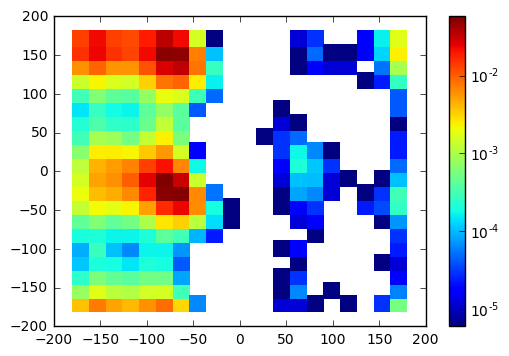

In [8]:
# compute the stationary distribution
pi = msm.stationary_distribution
# this is a very simple way to plot some quantity on the space of the dihedral angles
# here we plot pi
plt.scatter(centers[:,0],centers[:,1],c=pi,norm=matplotlib.colors.LogNorm(),s=150,marker='s',edgecolor='None')
plt.colorbar()

**exercise**: compute PCCA memberships

In [9]:
# solution
memberships = msm.pcca(3).memberships

Using `np.where(somedata>threshold)[0]` we can extract the array indices
of the elements that fulfill the condition `somedata>threshold`.
In other words if `indices=np.where(somedata>threshold)[0]` then `somedata[i]>threshold` for all `i` in `indices`.

**exercise**: for each PCCA set, extract the indices of those states that have large memberships, e. g. membership > 0.75. These can be considered as the cores of the PCCA sets.

In [10]:
# solution
cutoff = 0.7
A = np.where(memberships[:,0]>cutoff)[0]
B = np.where(memberships[:,1]>cutoff)[0]
C = np.where(memberships[:,2]>cutoff)[0]

Try to plot the locations of the core sets in dihedral space.
Consider for example the (arbitrary) set of micro-states:

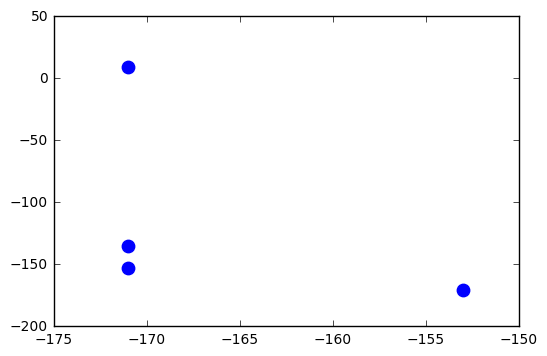

In [11]:
S=[1,2,10,20]
plt.scatter(centers[S,0],centers[S,1],color='b',s=80)
# alternative for the color argument are: 'b','g','r','k' (that's black), 'y'
# exercise: plot PCCA sets

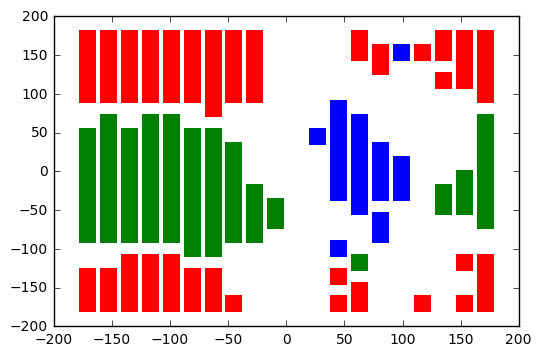

In [12]:
# solution
plt.scatter(centers[A,0], centers[A,1], color='b', s=150, marker='s', edgecolor='None')
plt.scatter(centers[B,0], centers[B,1], color='g', s=150, marker='s', edgecolor='None')
plt.scatter(centers[C,0], centers[C,1], color='r', s=150, marker='s', edgecolor='None')

**exercise**: compute MFPT between the PCCA core sets (pick some which are interesting)

In [13]:
# solution
msm.mfpt(B,A)/1000.0 # ns

47.506402464977597

**exercises**: compute the forward comittor (between two PCCA core sets) and show it in dihedral space
just like we did with pi but now with qplus

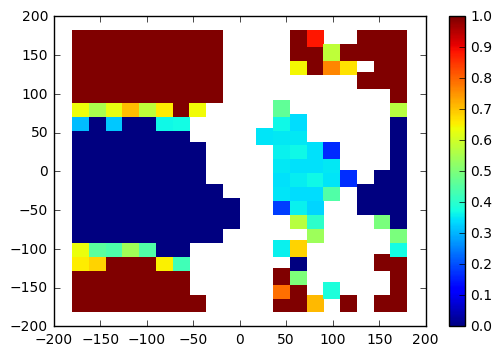

In [14]:
# solution
tpt = pyemma.msm.tpt(msm, B, C)
qp=tpt.forward_committor
plt.scatter(centers[:,0],centers[:,1],c=qp,s=150,marker='s',edgecolor='None')
plt.colorbar()

# exercise 3)

This is a very simplified four-state model of combined binding and conformational change. 
<img src='../tpt_data/ifcs.png'>
We want to investigate it with TPT. Set A is state (0), the unbound state with the ligand in the mismatched conformation. Set B is the state (3), the bound state with the ligand in the matched conformation. 
The system can take one of two routes:
- through (2), the bound state with the ligand in the mismatched conformation.
  On the pathway (0),(2),(3) binding happens before the conformational change. This is called "induced fit".
- through (1), the unbound state with the ligand in the matched state
  On the pathway (0),(1),(3) binding happens after the conformational change. This is called "conformational selection" or "selected fit".
  
For the values of p_01, p_10, p_23, p_32, p_20, p_31 we can assume some arbitrary values, like 0.1 for all of them. The result that we want to know doesn't depend on the precise values.
The transition rates from (0) to (2) and form (1) to (3) depend on the ligand concentration L. For the sake of simplicity we can just set p_02 = L and p_13 = L with L<0.9.

Chose a value for L and compute the flux f_if along the induced fit pathway and the flux f_cs along conformational selection pathway. There is some flux conservation, that you can use to make the analysis easier.
Compute the ratio of the fluxes f_if/f_cs. How does this ratio change depending on the ligand concentration?

In [15]:
P = np.zeros((4,4))
P[0,1] = 0.1
P[1,0] = 0.1
P[2,3] = 0.1
P[3,2] = 0.1
P[2,0] = 0.1
P[3,1] = 0.1
L = 0.3
P[0,2] = L
P[1,3] = L
np.fill_diagonal(P,1-P.sum(axis=1)) # normalize the matrix

In [16]:
msm = pyemma.msm.markov_model(P)
tpt = pyemma.msm.tpt(msm, [0], [3])

In [17]:
f_if = tpt.net_flux[0,2]
f_cs = tpt.net_flux[0,1]
print('IF', f_if, 'CS:', f_cs)
print('ratio IF/CS', f_if/f_cs)

IF 0.01875 CS: 0.009375
ratio IF/CS 2.0


In [18]:
# make sure that flux is conserved
# this should print the same as f_if, f_cs
print(tpt.net_flux[2,3], tpt.net_flux[1,3])

0.01875 0.009375


In [19]:
# solution: f_if/f_cs increases with increasing ligand concentration